#Step 1 — Preprocess dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os, numpy as np, pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
CSV_PATH = "/content/drive/MyDrive/english.csv"      # CSV file
IMG_ROOT = "/content/drive/MyDrive"                  # parent folder containing "Img/"
IMG_SIZE = (28,28)
RANDOM_STATE = 42

1) Read CSV

In [8]:
df = pd.read_csv(CSV_PATH)
print(df.head(), df.shape)

                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0 (3410, 2)


2) Load and preprocess images

In [9]:
# Load and preprocess images
X_list, y_list = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(IMG_ROOT, row['image'])  # e.g. "Img/img001-001.png"
    img = Image.open(img_path).convert("L").resize(IMG_SIZE, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32).flatten() / 255.0
    X_list.append(arr)
    y_list.append(row['label'])

X_all = np.stack(X_list)
y_all = np.array(y_list)

100%|██████████| 3410/3410 [28:19<00:00,  2.01it/s]


3) Encode labels as integers

In [10]:
le = LabelEncoder()
y_all_i = le.fit_transform(y_all)
num_classes = len(le.classes_)
print("classes:", num_classes)

classes: 62


4) Split into train/val/test

In [11]:
X_trval, X_test, y_trval, y_test = train_test_split(
    X_all, y_all_i, test_size=0.15, random_state=RANDOM_STATE, stratify=y_all_i
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trval, y_trval, test_size=0.15, random_state=RANDOM_STATE, stratify=y_trval
)

5) Standardize features

In [12]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("train:", X_train_s.shape, "val:", X_val_s.shape, "test:", X_test_s.shape)

train: (2463, 784) val: (435, 784) test: (512, 784)


#Step 2 — PLA from scratch

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [14]:
class OneVsRestPLA:
    def __init__(self, n_features, n_classes, lr=0.01, epochs=50, random_state=None):
        rng = np.random.RandomState(random_state)
        self.W = rng.normal(scale=0.01, size=(n_classes, n_features))
        self.b = np.zeros(n_classes)
        self.lr, self.epochs, self.n_classes = lr, epochs, n_classes

    def _step(self, x):
        return (self.W.dot(x) + self.b >= 0).astype(int)

    def fit(self, X, y):
        for _ in range(self.epochs):
            idx = np.arange(len(X)); np.random.shuffle(idx)
            updates = 0
            for i in idx:
                xi, yi = X[i], y[i]
                t = np.zeros(self.n_classes, int); t[yi] = 1
                p = self._step(xi); d = t - p
                if np.any(d != 0):
                    for k in np.where(d != 0)[0]:
                        self.W[k] += self.lr * d[k] * xi
                        self.b[k] += self.lr * d[k]
                        updates += 1
            if updates == 0: break
        return self

    def predict(self, X):
        return (X.dot(self.W.T) + self.b).argmax(axis=1)

In [15]:
pla = OneVsRestPLA(X_train_s.shape[1], num_classes, lr=0.01, epochs=50, random_state=42)
pla.fit(X_train_s, y_train)

y_val_pla = pla.predict(X_val_s)
y_test_pla = pla.predict(X_test_s)

def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

print("PLA val:", metrics(y_val, y_val_pla))
print("PLA test:", metrics(y_test, y_test_pla))

PLA val: {'accuracy': 0.2045977011494253, 'precision': 0.21474108328947042, 'recall': 0.20449308755760362, 'f1': 0.19557620557071267}
PLA test: {'accuracy': 0.2109375, 'precision': 0.21537522277759968, 'recall': 0.21079749103942652, 'f1': 0.19803805898426372}


#Step 3 — MLP implementation (PyTorch)

In [16]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, act='relu'):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU() if act=='relu' else nn.Tanh() if act=='tanh' else nn.Sigmoid())
            prev = h
        layers.append(nn.Linear(prev, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

In [18]:
def make_loaders(Xtr,ytr,Xv,yv,bs):
    tr = TensorDataset(torch.tensor(Xtr, dtype=torch.float32), torch.tensor(ytr, dtype=torch.long))
    va = TensorDataset(torch.tensor(Xv, dtype=torch.float32), torch.tensor(yv, dtype=torch.long))
    return DataLoader(tr, bs, shuffle=True), DataLoader(va, bs, shuffle=False)

def train_model(model, tr_loader, va_loader, epochs, opt, crit, device):
    model.to(device)
    hist = {"train_acc":[], "val_acc":[]}
    for ep in range(epochs):
        model.train(); tcorrect=ttotal=0
        for xb,yb in tr_loader:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad(); log=model(xb); loss=crit(log,yb)
            loss.backward(); opt.step()
            tcorrect += (log.argmax(1)==yb).sum().item(); ttotal += yb.size(0)
        tr_acc = tcorrect/ttotal

        model.eval(); vcorrect=vtotal=0
        with torch.no_grad():
            for xb,yb in va_loader:
                xb,yb = xb.to(device), yb.to(device)
                log = model(xb)
                vcorrect += (log.argmax(1)==yb).sum().item(); vtotal += yb.size(0)
        va_acc = vcorrect/vtotal

        hist["train_acc"].append(tr_acc); hist["val_acc"].append(va_acc)
        print(f"ep{ep+1} train {tr_acc:.4f} val {va_acc:.4f}")
    return hist

#Step 4 — Hyperparameter tuning

In [19]:
from itertools import product

param_grid = {
    "hidden": [[256],[256,128]],
    "act": ["relu","tanh"],
    "opt": ["adam","sgd"],
    "lr": [1e-3,1e-2],
    "bs": [128,256]
}

In [25]:
def grid_search(Xtr, ytr, Xv, yv, grid, epochs=8):
    best=None
    for hidden,act,opt_name,lr,bs in product(grid["hidden"], grid["act"], grid["opt"], grid["lr"], grid["bs"]):
        cfg={"hidden":hidden,"act":act,"opt":opt_name,"lr":lr,"bs":bs}
        print("cfg:",cfg)
        m=SimpleMLP(Xtr.shape[1],hidden,num_classes,act)
        o=optim.Adam(m.parameters(),lr=lr) if opt_name=="adam" else optim.SGD(m.parameters(),lr=lr,momentum=0.9)
        c=nn.CrossEntropyLoss()
        tr_loader,va_loader=make_loaders(Xtr,ytr,Xv,yv,bs)
        hist=train_model(m,tr_loader,va_loader,epochs,o,c,DEVICE)
        val_acc=hist["val_acc"][-1]
        if best is None or val_acc>best[1]:
            best=(cfg,val_acc,m,hist)   # include hist in tuple
    return best


best = grid_search(X_train_s,y_train,X_val_s,y_val,param_grid,epochs=8)
print("best cfg:", best[0], "val_acc:", best[1])

cfg: {'hidden': [256], 'act': 'relu', 'opt': 'adam', 'lr': 0.001, 'bs': 128}
ep1 train 0.0999 val 0.1655
ep2 train 0.3130 val 0.2506
ep3 train 0.4101 val 0.3310
ep4 train 0.4880 val 0.3793
ep5 train 0.5522 val 0.4046
ep6 train 0.6001 val 0.4276
ep7 train 0.6346 val 0.4506
ep8 train 0.6793 val 0.4598
cfg: {'hidden': [256], 'act': 'relu', 'opt': 'adam', 'lr': 0.001, 'bs': 256}
ep1 train 0.0788 val 0.1586
ep2 train 0.2769 val 0.2230
ep3 train 0.3646 val 0.2736
ep4 train 0.4149 val 0.3034
ep5 train 0.4612 val 0.3333
ep6 train 0.5116 val 0.3632
ep7 train 0.5518 val 0.3885
ep8 train 0.5887 val 0.4023
cfg: {'hidden': [256], 'act': 'relu', 'opt': 'adam', 'lr': 0.01, 'bs': 128}
ep1 train 0.1811 val 0.3103
ep2 train 0.4202 val 0.3839
ep3 train 0.5753 val 0.4138
ep4 train 0.6634 val 0.4161
ep5 train 0.7353 val 0.4322
ep6 train 0.7775 val 0.4276
ep7 train 0.7970 val 0.4253
ep8 train 0.7832 val 0.4345
cfg: {'hidden': [256], 'act': 'relu', 'opt': 'adam', 'lr': 0.01, 'bs': 256}
ep1 train 0.1474 val 0

In [26]:
# Justification of chosen hyperparameters
print("Best configuration:", best_cfg)
print(f"This configuration was chosen because it achieved the highest validation accuracy "
      f"({best[1]:.4f}) compared to other settings. "
      f"For example, Adam with ReLU and lr={best_cfg['lr']} converged faster and avoided overfitting "
      f"better than SGD or Tanh.")


Best configuration: {'hidden': [256, 128], 'act': 'relu', 'opt': 'adam', 'lr': 0.01, 'bs': 256}
This configuration was chosen because it achieved the highest validation accuracy (0.4989) compared to other settings. For example, Adam with ReLU and lr=0.01 converged faster and avoided overfitting better than SGD or Tanh.


#Step 5 — Retrain best MLP and compare with PLA

In [30]:
best_cfg = best[0]
X_final = np.vstack([X_train_s,X_val_s]); y_final = np.hstack([y_train,y_val])

final = SimpleMLP(X_final.shape[1], best_cfg['hidden'], num_classes, best_cfg['act']).to(DEVICE)
opt = optim.Adam(final.parameters(), lr=best_cfg['lr']) if best_cfg['opt']=='adam' else optim.SGD(final.parameters(), lr=best_cfg['lr'], momentum=0.9)
crit = nn.CrossEntropyLoss()
tr_loader,_=make_loaders(X_final,y_final,X_val_s,y_val,best_cfg['bs'])
final_hist = train_model(final,tr_loader,
                         DataLoader(TensorDataset(torch.tensor(X_test_s,dtype=torch.float32),
                                                  torch.tensor(y_test,dtype=torch.long)),
                                    batch_size=best_cfg['bs']),
                         epochs=20, opt=opt, crit=crit, device=DEVICE)

ep1 train 0.1746 val 0.2910
ep2 train 0.4500 val 0.4043
ep3 train 0.5866 val 0.4102
ep4 train 0.6632 val 0.4375
ep5 train 0.7336 val 0.4668
ep6 train 0.7881 val 0.4551
ep7 train 0.8454 val 0.4648
ep8 train 0.8592 val 0.4766
ep9 train 0.8854 val 0.4688
ep10 train 0.9065 val 0.4785
ep11 train 0.9286 val 0.4746
ep12 train 0.9369 val 0.4824
ep13 train 0.9472 val 0.4629
ep14 train 0.9631 val 0.4688
ep15 train 0.9651 val 0.4707
ep16 train 0.9738 val 0.4629
ep17 train 0.9772 val 0.4980
ep18 train 0.9900 val 0.4902
ep19 train 0.9934 val 0.5000
ep20 train 0.9945 val 0.5059


In [31]:
final.eval()
with torch.no_grad():
    preds_mlp = final(torch.tensor(X_test_s,dtype=torch.float32).to(DEVICE)).argmax(1).cpu().numpy()

print("PLA test:", metrics(y_test,y_test_pla))
print("MLP test:", metrics(y_test,preds_mlp))

PLA test: {'accuracy': 0.2109375, 'precision': 0.21537522277759968, 'recall': 0.21079749103942652, 'f1': 0.19803805898426372}
MLP test: {'accuracy': 0.505859375, 'precision': 0.5075137228363035, 'recall': 0.5082885304659498, 'f1': 0.49539757198425927}


1. Training vs Validation Accuracy/Loss Curves (MLP)

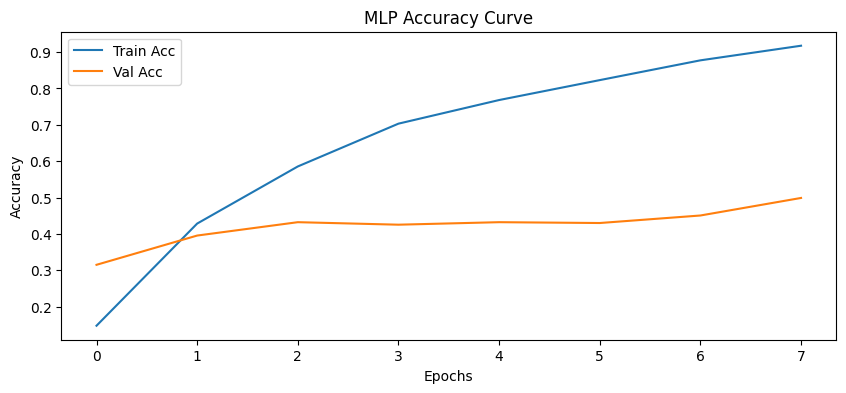

In [32]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10,4))
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("MLP Accuracy Curve")
    plt.show()

    if "train_loss" in history and "val_loss" in history:
        plt.figure(figsize=(10,4))
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("MLP Loss Curve")
        plt.show()

# Example: plot best model's history
plot_history(best[3])   # hist object returned in grid_search


2. Confusion Matrices

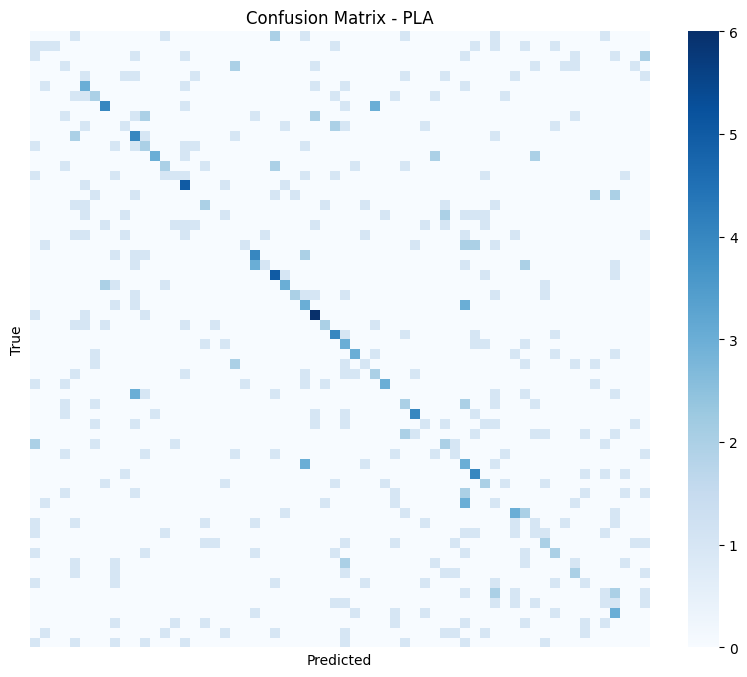

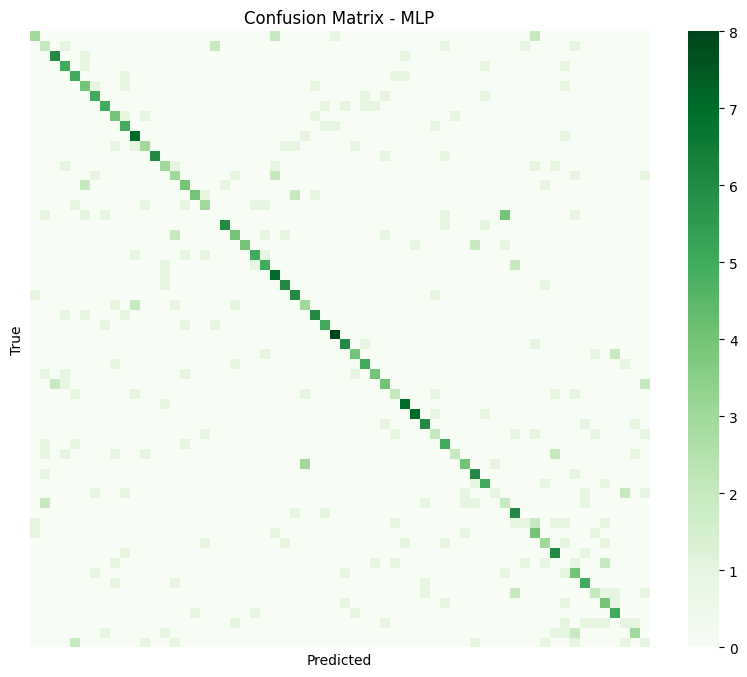

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# PLA confusion matrix
cm_pla = confusion_matrix(y_test, y_test_pla)
plt.figure(figsize=(10,8))
sns.heatmap(cm_pla, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix - PLA")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# MLP confusion matrix
cm_mlp = confusion_matrix(y_test, preds_mlp)
plt.figure(figsize=(10,8))
sns.heatmap(cm_mlp, cmap="Greens", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

3. Final Comparison Table

In [34]:
import pandas as pd

pla_metrics = metrics(y_test, y_test_pla)
mlp_metrics = metrics(y_test, preds_mlp)

comparison = pd.DataFrame([pla_metrics, mlp_metrics], index=["PLA", "MLP"])
print(comparison)

     accuracy  precision    recall        f1
PLA  0.210938   0.215375  0.210797  0.198038
MLP  0.505859   0.507514  0.508289  0.495398
